# SDLE - Sistemas Distribuídos em Larga Escala
## Trabalho prático

In [2]:
import random
import matplotlib.pyplot as plt
import networkx as nx
import heapq as hq

Geração de grafos conectados.

In [3]:
def connectedGraph(nVertices):
    # Initialize the graph
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(nVertices))

    # List all possible edges
    edges = list(nx.non_edges(G))
    random.shuffle(edges)
    while not nx.is_connected(G):
        x, y = edges.pop()
        G.add_edge(x, y)

    return G

Exibição gráfica do grafo gerado.

In [4]:
def drawGraph(G):
    plt.figure(figsize = (16,8), dpi = 200)
    nx.draw_networkx(G,
                     with_labels = True,
                     style = "solid",
                     node_size = 700,
                     node_color = "orange",
                     font_size = 14,
                     font_color = "black",
                     font_weight = "bold")
    plt.show()

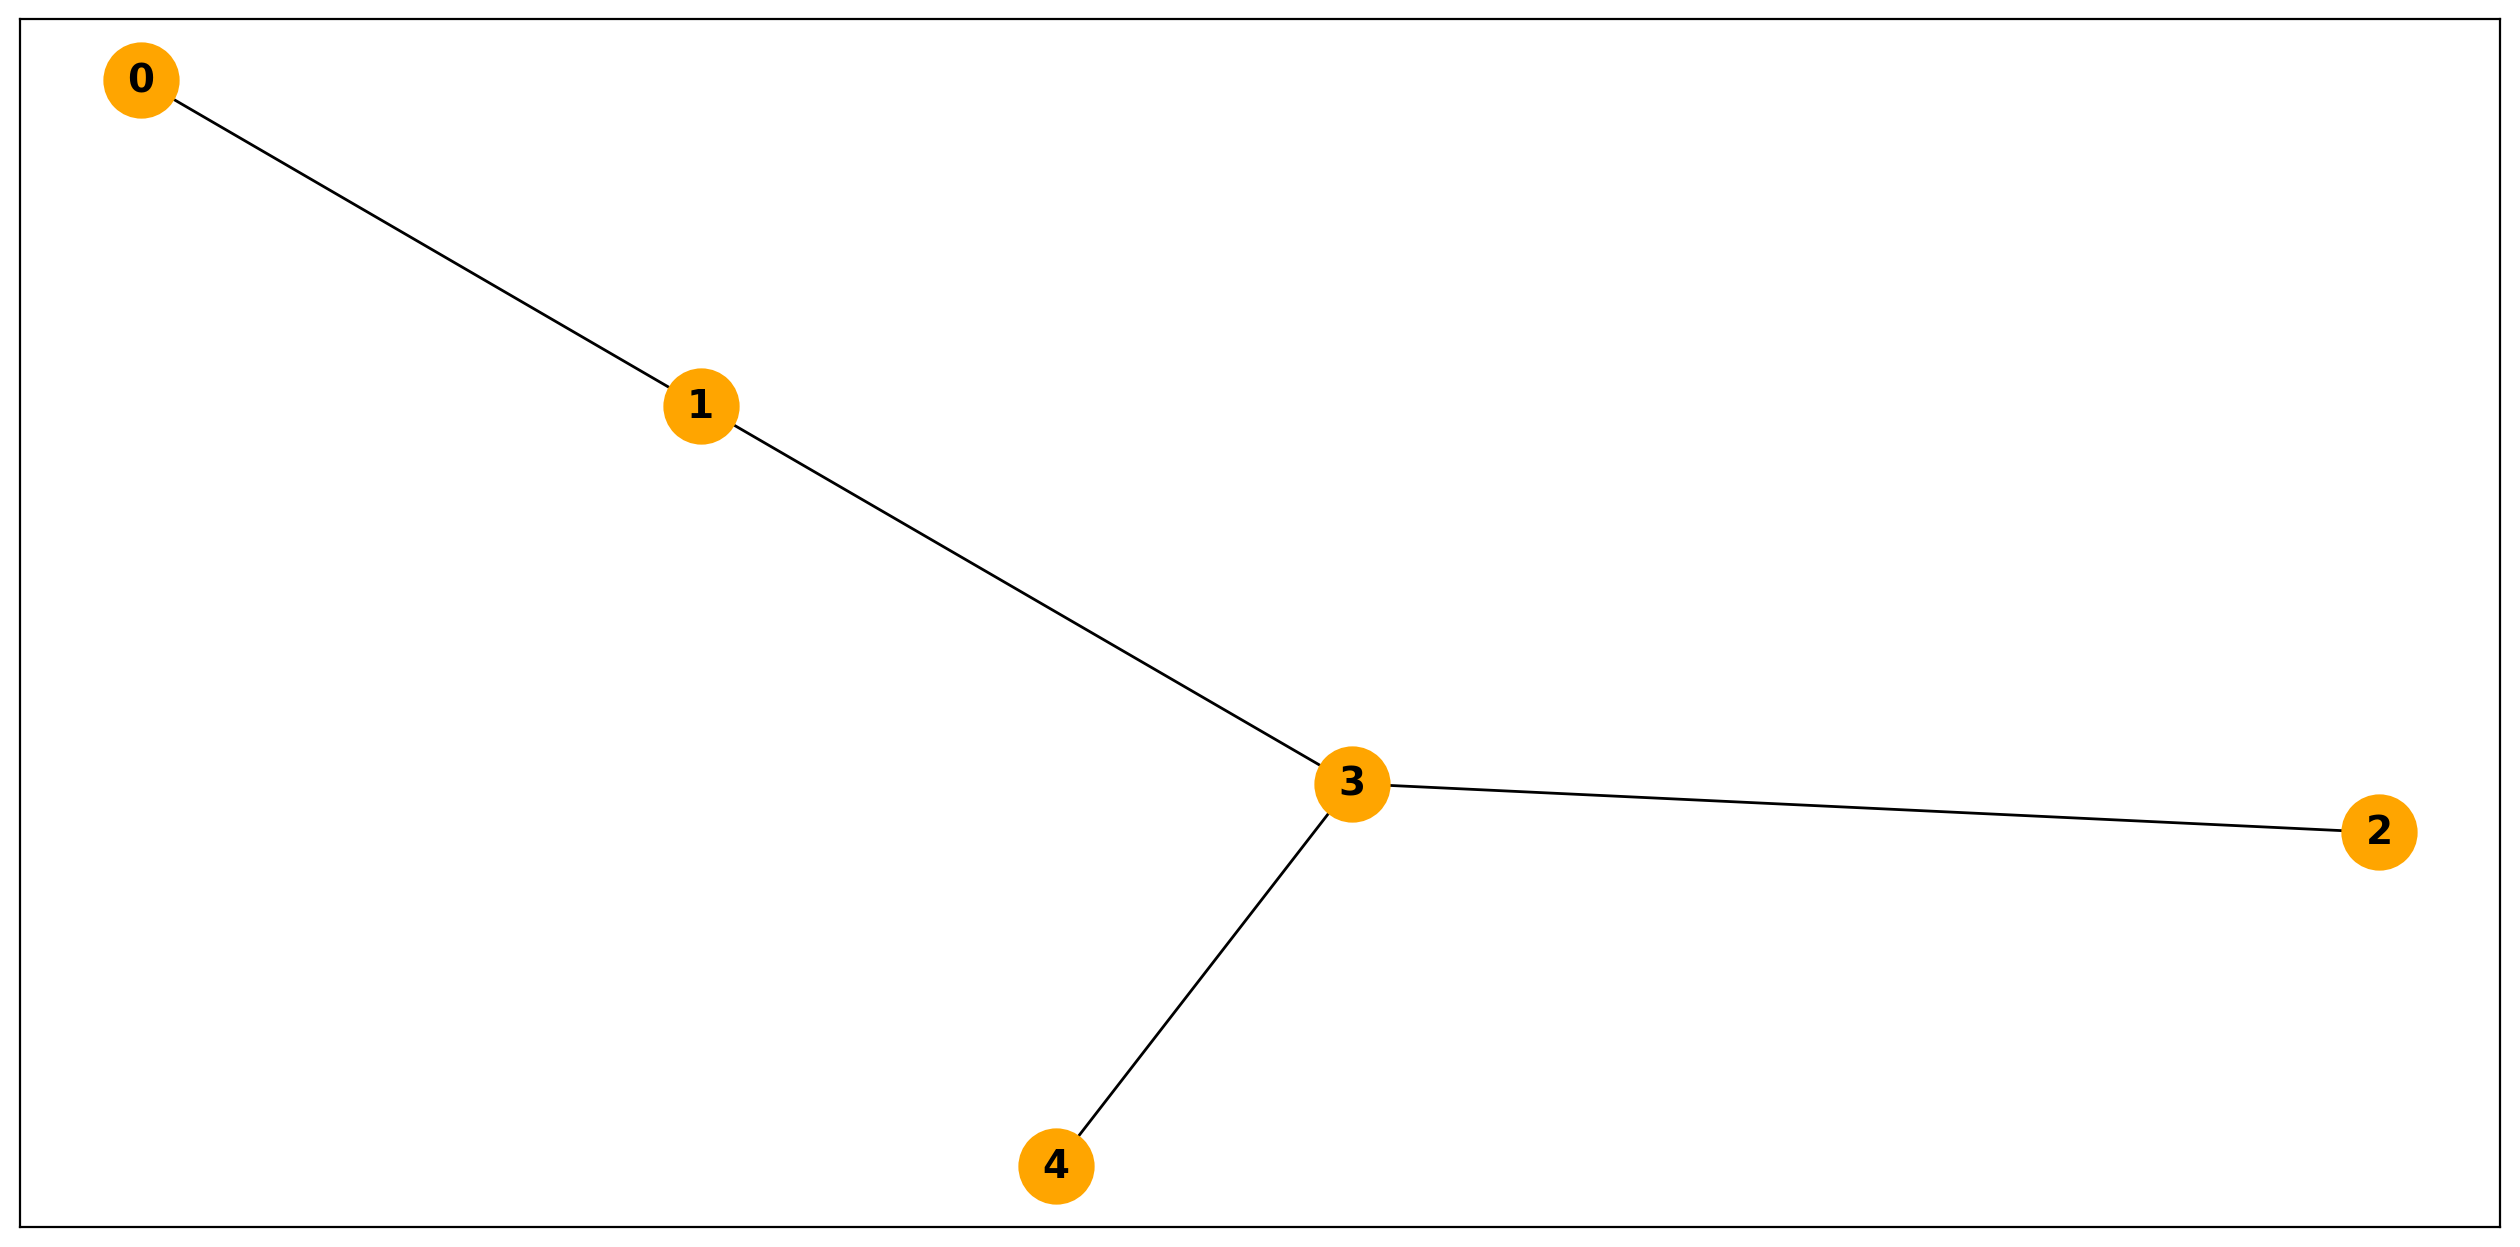

In [6]:
G = connectedGraph(5)
drawGraph(G)

Classe relativa ao algoritmo escolhido, isto é, ***flow updating*** :

In [ ]:
class FlowUpdating:
    def __init__(self, neighbors, inputValue, timeout):
        self.timeout = timeout
        self.messages = []
        self.neighbors = neighbors
        self.f = {}
        self.e = {}
        for n in neighbors:
            self.f[n] = 0
            self.e[n] = 0
        self.v = inputValue

    def gen_message(self):
        messages = [("TIMEOUT", self.timeout, True)]
        for n in self.neighbors:
            msg = (self.f[n], self.e[n])
            messages.append(("FLOW", (n, msg)))
        return messages

    def calculateEstimate(self):
        sumF = 0
        sumE = 0
        for n in self.neighbors:
            sumF += self.f[n]
            sumE += self.e[n]
        return (self.v - sumF + sumE) / (len(self.neighbors) + 1)

    def state_transition(self):
        for m in self.messages:
            src = m[0]
            (f, e) = m[1]
            self.f[src] = -f
            self.e[src] = e

        newE = self.calculateEstimate()
        stop = True
        for n in self.neighbors:
            print(round(newE, 2), round(self.e[n], 2))
            if round(newE, 2) != round(self.e[n], 2):
                stop = False
            self.f[n] += newE - self.e[n]
            self.e[n] = newE

        return stop

    def handle(self, src, msg):
        if msg == "INITIAL":
            return self.gen_message()
        else:
            if msg[0] == "FLOW":
                self.messages.append((src, msg[1]))
            else: # timeout message, end of round
                if not self.state_transition():
                    return self.gen_message()
        return []

Classe *Simulator* :

In [ ]:
class Simulator:
    def __init__(self, nodes, distances, faultProbability, viewChange):
        self.nodes = nodes
        self.distances = distances
        self.currentTime = 0
        self.pending = [] # [(delay, (src, dest, msg))]
        self.faultProbability = faultProbability
        self.viewChange = viewChange

    def start(self):
        for n in self.nodes:
            event = (0, (None, n, "INITIAL"))
            hq.heappush(self.pending, event)

        # Add first view change
        if self.viewChange != -1:
            hq.heappush(self.pending, (self.viewChange, (float("+infinity"), None, "VIEWCHANGE")))

        return self.runLoop()

    def runLoop(self):
        sent_messages = len(self.pending)
        while len(self.pending) != 0:
            if len(self.pending) == 1:
                (delay, (src, dest, msg)) = self.pending[0]
                if msg == "VIEWCHANGE":
                    break

            (delay, (src, dest, msg)) = hq.heappop(self.pending)
            print(dest, "received", msg, "from", src, "at", delay)
            self.currentTime = delay

            # Message to change the view
            if msg == "VIEWCHANGE":
                print("View changing ...")

                vc = (self.currentTime + self.viewChange, (float("+infinity"), None, "VIEWCHANGE"))
                print("VIEWCHANGE", vc)
                hq.heappush(self.pending, vc)

                newGraph = completeGraph(len(self.nodes))
                drawGraph(newGraph)
                self.distances, self.nodes = newNeighborsAndDistances(newGraph, self.nodes, random.randrange(10), False)
                continue

            # Message between two nodes or a timeout
            newEvents = self.nodes[dest].handle(src, msg)

            if newEvents:
                sent_messages += len(newEvents)
                for x in newEvents:
                    if x[0] != "TIMEOUT":
                        (msgType, (newMsgDest, newMsg)) = x
                        if self.faultProbability != 0 and random.randrange(round(1/self.faultProbability)) == 0: # fault-injection mechanism
                            print("Dropped", newMsg, "from", dest, "to", newMsgDest)
                            continue
                        dist = 0
                        if (dest, newMsgDest) not in self.distances and (newMsgDest, dest) not in self.distances:
                            print("Dropped one message from", dest, "to", newMsgDest, "because they are no longer neighbors")
                            continue
                        if dest < newMsgDest:
                            dist = self.distances[(dest, newMsgDest)]
                        else:
                            dist = self.distances[(newMsgDest, dest)]

                        ev = (self.currentTime + dist, (dest, newMsgDest, (msgType, newMsg)))
                        hq.heappush(self.pending, ev)
                    else:
                        (msgType, timeout, newMsg) = x
                        ev = (self.currentTime + timeout, (dest, dest, (msgType, timeout, newMsg)))
                        hq.heappush(self.pending, ev)

        print()
        return sent_messages, self.currentTime

Função que determina os pesos das arestas do grafo gerado, instanciando o algoritmo em causa :

In [ ]:
def newNeighborsAndDistances(G, nodes):
    distances = {}
    for node in G.nodes():
        neighbors = set(G.neighbors(node))
        nodes[node] = FlowUpdating(neighbors, 5, 3)

        for neighbor in neighbors:
            if node < neighbor:
                distances[(node, neighbor)] = 1 # rand.randrange(10)
            else:
                distances[(neighbor, node)] = 1 # rand.randrange(10)

    return distances, nodes

In [ ]:
def main():
    N = 5 # number of rounds
    fanout = 1
    messages_sent = 0
    rounds = 0
    max_rounds = float("-infinity")
    min_rounds = float("+infinity")

    for i in range(N):
        distances, nodes = newNeighborsAndDistances(G, {})

        fp = 0    # fault-probability       - probability for a message to be lost
        vcp = -1  # view-change periodicity - every vcp seconds, the set of neighbors change
        sim = Simulator(nodes, distances, fp, vcp)
        x, y = sim.start()
        messages_sent += x
        rounds += y

        if y > max_rounds:
            max_rounds = y
        if y < min_rounds:
            min_rounds = y

    print("Average rounds:", float(rounds / N))
    print("Average messages sent:", float(messages_sent / N))
    print("Min rounds:", min_rounds)
    print("Max rounds:", max_rounds)

In [ ]:
main()